In [ ]:
import warnings

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()



sns.set(style="whitegrid")


warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

sns.set(style="whitegrid")


warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)
# Eigene Module (utils)
from utils.config import (
    OCEAN_POINTS,
)
from utils.ml_helper_functions import load_data

OCEAN_POINTS = 30

/gxfs_home/geomar/smomw693/Documents/GEOMAR-DeepLearning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_data()


Loading data from:
../data/numerical_data/points30
../data/numerical_data/points10

Loading ocean, weather and insitu data...



Shapes of loaded DataFrames before feature engineering:
Ocean DataFrame: (9415187, 14)
Weather DataFrame: (2018400, 22)
Insitu DataFrame: (20161, 2)

Feature engineering...

Shapes of loaded DataFrames after feature engineering:
Ocean DataFrame: (9415187, 11)
Weather DataFrame: (2018400, 8)
Insitu DataFrame: (20161, 2)

Converting DataFrames to xarray DataArrays...

Running EOF analysis on ocean and weather data...

Converting DataArrays with PCs back to DataFrames...

Merging PCs with insitu data...

Shape of merged DataFrame with PCs: (20161, 98)

Preparing ML data...

Sum of NaN values in each column:
ds              0
bottomT_PC_1    0
bottomT_PC_2    0
bottomT_PC_3    0
bottomT_PC_4    0
               ..
wind_v_PC_6     0
wind_v_PC_7     0
wind_v_PC_8     0
y               0
unique_id       0
Length: 99, dtype: int64
Shape of prepared ML DataFrame: (20161, 99)

Columns in the prepared DataFrame:
['ds', 'bottomT_PC_1', 'bottomT_PC_2', 'bottomT_PC_3', 'bottomT_PC_4', 'sla_PC_1', '

In [3]:
ts = df[['ds','y']]
ts

,ds,y
0,2022-12-03 00:00:00,0.487133
1,2022-12-03 01:00:00,0.463563
2,2022-12-03 02:00:00,0.373853
3,2022-12-03 03:00:00,0.285051
4,2022-12-03 04:00:00,0.238839
...,...,...
20156,2025-03-21 20:00:00,0.483333
20157,2025-03-21 21:00:00,0.496667
20158,2025-03-21 22:00:00,0.538333
20159,2025-03-21 23:00:00,0.550000


## 1. Schritt: Stationarität prüfen → d

In [ ]:
# import adfuller

In [5]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print(f'p-Wert: {pvalue}')
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary -> d = 0')
    else:
        print('The series is NOT stationary ')

check_stationarity(ts['y'])

p-Wert: 9.382157939150382e-25
The series is stationary -> d = 0


Text(0, 0.5, 'Sea Level (m)')

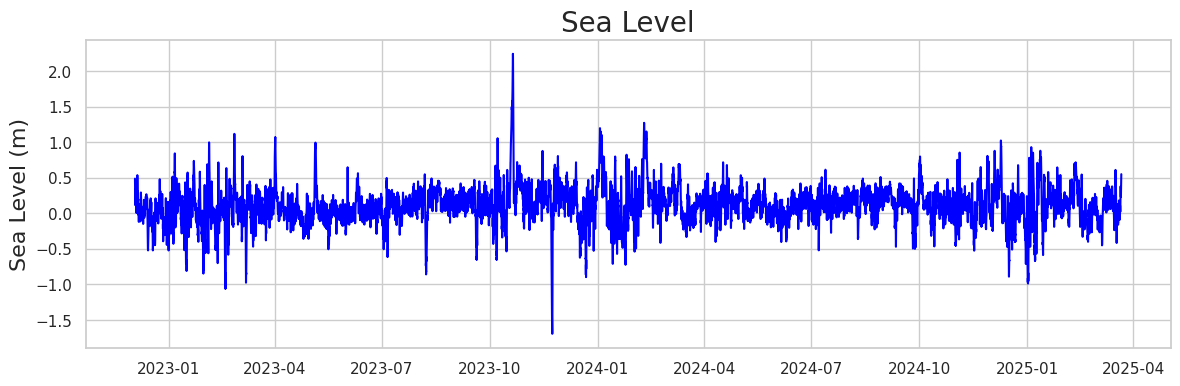

In [7]:
plt.figure(figsize=(14,4))
plt.plot(ts['ds'], ts['y'], color='blue')
plt.title('Sea Level', fontsize=20)
plt.ylabel('Sea Level (m)', fontsize=16)

## 2. Schritt: p und q über ACF/PACF schätzen

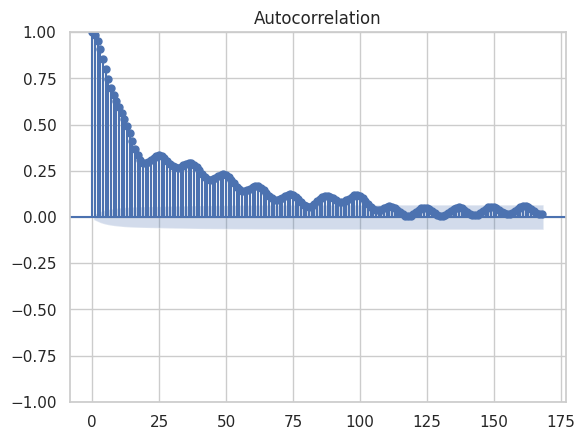

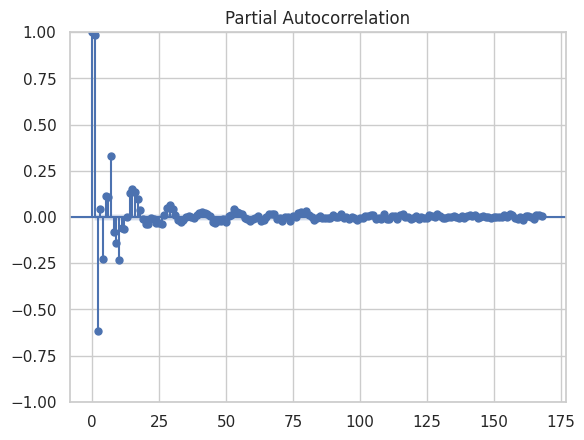

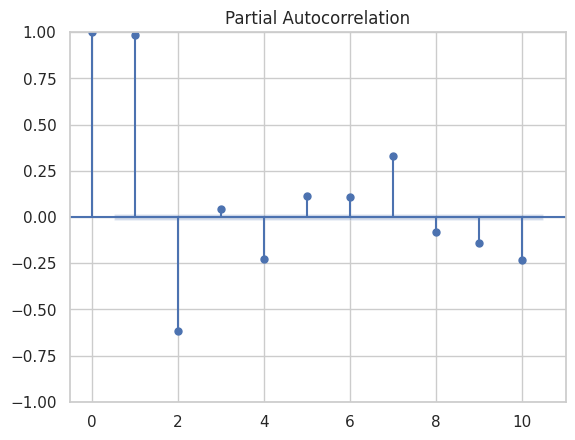

In [ ]:
plot_acf(ts['y'], lags=168)
plot_pacf(ts['y'], lags=168)

q = 24
# p = 7
plot_pacf(ts['y'], lags=10);

In [9]:
# Bestimmen von saisonalen Perioden
s = 24

## D

In [10]:
seasonal_diff = ts['y'].diff(s)

check_stationarity(seasonal_diff.dropna())
# D = 0

p-Wert: 0.0
The series is stationary -> d = 0


In [ ]:
# import auto_arima
from pmdarima import auto_arima

model = auto_arima(ts['y'], seasonal=True, m=24, trace=True, maxiter=100, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-78276.828, Time=181.43 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-66906.965, Time=2.07 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-76458.632, Time=24.38 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-76530.781, Time=44.73 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-66908.965, Time=0.63 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-78193.101, Time=202.19 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-78226.112, Time=152.96 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-78291.116, Time=469.92 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-78293.000, Time=349.01 sec
 ARIMA(1,1,2)(2,0,0)[24] intercept   : AIC=-77513.937, Time=305.11 sec
 ARIMA(2,1,1)(2,0,0)[24] intercept   : AIC=-77979.251, Time=228.53 sec
 ARIMA(3,1,2)(2,0,0)[24] intercept   : AIC=-78318.322, Time=398.32 sec
 ARIMA(3,1,2)(1,0,0)[24] intercept   : AIC=-78236.552, Time=161.43 sec
 ARIMA(3,1,2)(2,0,1)[24] intercept   : A

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                20161
Model:               SARIMAX(2, 1, 4)   Log Likelihood               40817.368
Date:                Fri, 13 Jun 2025   AIC                         -81620.736
Time:                        15:40:31   BIC                         -81565.356
Sample:                             0   HQIC                        -81602.624
                              - 20161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5537      0.007    225.344      0.000       1.540       1.567
ar.L2         -0.7905      0.005   -144.402      0.000      -0.801      -0.780
ma.L1         -0.9765      0.008   -129.043      0.0

In [ ]:
dd

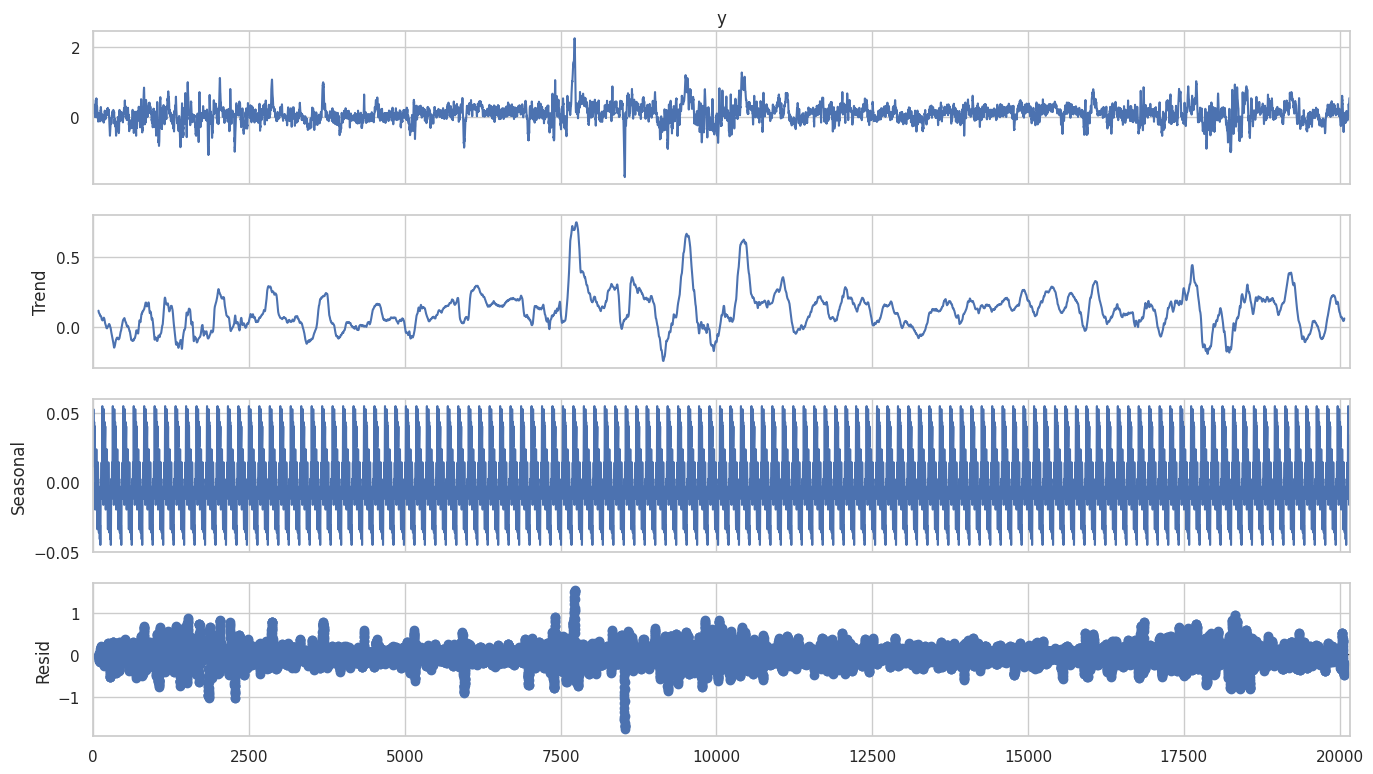

In [ ]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

df_insitu = ts.set_index('ds')
df_insitu.index = pd.DatetimeIndex(df_insitu.index)
df_insitu = df_insitu.asfreq('h')  # 'H' für stündliche Daten, ggf. anpassen

# Führe die Zerlegung mit period=24 (tägliche Saisonalität) durch
result = seasonal_decompose(ts['y'], model='additive', period=24*7)
fig = result.plot()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

ts_train = ts[ts['ds'] < '2025-01-01']
ts_test = ts[ts['ds'] >= '2025-01-01']
arima = ARIMA(ts_train['y'], order=(24,0,7))
model_fit = arima.fit()
predictions = model_fit.predict(start=ts_test.index[0], end=ts_test.index[-1])

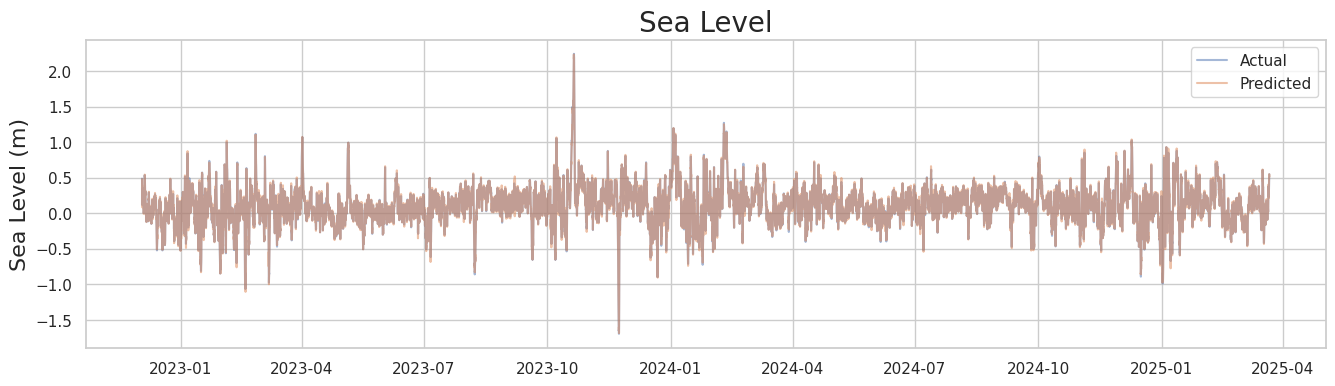

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df_insitu['slev'], label="Actual", alpha=0.5)
plt.plot(predictions, label="Predicted", alpha=0.5)
plt.title('Sea Level', fontsize=20)
plt.ylabel('Sea Level (m)', fontsize=16)
plt.legend()

In [ ]:
sarima = SARIMAX(df_insitu['slev'],
                order=(1,1,1),
                seasonal_order=(1,1,0,12))
predictions = sarima.fit().predict()

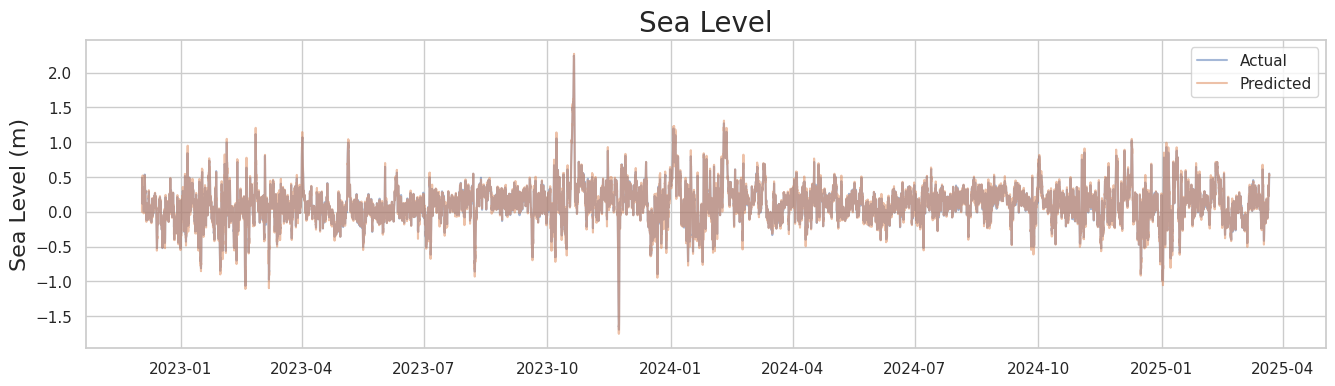

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(df_insitu['slev'], label="Actual", alpha=0.5)
plt.plot(predictions, label="Predicted", alpha=0.5)
plt.title('Sea Level', fontsize=20)
plt.ylabel('Sea Level (m)', fontsize=16)
plt.legend()

In [ ]:
# correlation of df_insitu['slev] and predictions
df_insitu['slev'].corr(predictions)

0.9881898320967512